In [74]:
import os
import numpy as np
from PIL import Image
import matplotlib
from matplotlib import pyplot,pylab
plt = pyplot
import scipy
import seaborn as sns
sns.set_style('white')
import string
import pandas as pd
import json
import pymongo as pm
from glob import glob
from IPython.display import clear_output
import itertools 
from random import sample
import importlib
from PIL import Image

### set up project paths

In [75]:
## root paths
curr_dir = os.getcwd()
proj_dir = os.path.abspath(os.path.join(curr_dir,'..'))
data_dir = os.path.abspath(os.path.join(curr_dir,'..','data')) ## use relative paths
stim_dir = os.path.abspath(os.path.join(proj_dir,'stimuli'))
analysis_dir = os.path.abspath(os.path.join(curr_dir,'..','analysis')) ## use relative paths
plot_dir =  os.path.abspath(os.path.join(curr_dir,'..','results','plots'))
csv_dir = os.path.join(proj_dir, 'results','csv')
sketch_dir = os.path.abspath(os.path.join(proj_dir,'sketches'))


## add helpers to python path
import sys
if os.path.join(proj_dir, 'utils') not in sys.path:
    sys.path.append(os.path.join(proj_dir, 'utils'))
import utils as h    


### inspect stims and get image paths 

In [76]:
## get sketch paths
path_to_sketches = sketch_dir
im_list = h.list_files(sketch_dir)
assert len(im_list)==32*60 # num trials per game * num kosher games


In [77]:
## sort stims in place
importlib.reload(h)
h.sort_nicely(im_list)


/Users/alles/iterated_number/sketches/2824-66e43315-075a-431f-86d4-6eea7f135aa2•owl_4•6•shape•owl_5_012.png


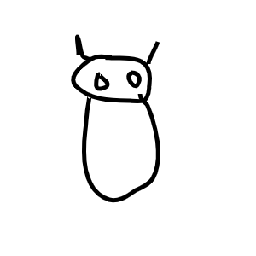

In [78]:
## manually inspect the images
imsize = 256
fname = im_list[500]
print(fname)
Image.open(fname).resize((imsize,imsize))

### upload stims to s3

In [79]:
import boto3
import botocore

In [80]:
bucket_name = 'iternum-sketches'
full_sketch_paths = h.list_files(path_to_sketches)
h.sort_nicely(full_sketch_paths)

In [81]:
## helper to speed things up by not uploading images if they already exist, can be overriden 
def check_exists(s3, bucket_name, stim_name):
    try:
        s3.Object(bucket_name,stim_name).load()    
        return True
    except botocore.exceptions.ClientError as e:    
        if (e.response['Error']['Code'] == "404"):
            print('The object does not exist.')
            return False
        else:
            print('Something else has gone wrong with {}'.format(stim_name))
            


In [87]:
print(check_exists(boto3.resource('s3'), bucket_name, fname.split('/')[-1]))
print(fname.split('/')[-1])
# print(len(im_list))

# print(full_sketch_paths[5])

True
2824-66e43315-075a-431f-86d4-6eea7f135aa2•owl_4•6•shape•owl_5_012.png


In [89]:
reallyRun = 0
if reallyRun: 
    ## tell user some useful information
    print('Path to stimuli is : {}'.format(path_to_sketches))
    print('Uploading to this bucket: {}'.format(bucket_name))

    ## establish connection to s3 
#     s3 = boto3.resource('s3')
    s3 = boto3.resource('s3', 
                  region_name='us-east-1', 
                  aws_access_key_id="STORE THIS LOCALLY! Boto3 should be accessing ~/.aws/credentials but it's not for some reason",     
                  aws_secret_access_key='THIS TOO!')
    
    ## create a bucket with the appropriate bucket name
    try: 
        b = s3.create_bucket(Bucket=bucket_name) 
        print('Created new bucket.')
    except Exception as e:
        print(e)
        b = s3.Bucket(bucket_name)
        print('Bucket already exists.')

    ## do we want to overwrite files on s3?
    overwrite = False
    
    ## set bucket and objects to public
    b.Acl().put(ACL='public-read') ## sets bucket to public

    ## now let's loop through stim paths and actually upload to s3 (woot!)
    for i,path_to_file in enumerate(full_sketch_paths):
        stim_name = path_to_file.split('/')[-1]
        if ((check_exists(s3, bucket_name, stim_name)==False) | (overwrite==True)):
            print('Now uploading {} | {} of {}'.format(path_to_file.split('/')[-1],(i+1),len(full_sketch_paths)))
            s3.Object(bucket_name,stim_name).put(Body=open(path_to_file,'rb')) ## upload stimuli
            s3.Object(bucket_name,stim_name).Acl().put(ACL='public-read') ## set access controls
        else: 
            print('Skipping {} | {} of {} because it already exists.'.format(path_to_file.split('/')[-1],(i+1),len(full_stim_paths)))
        clear_output(wait=True)

    print('Done uploading images!')

Path to stimuli is : /Users/alles/iterated_number/sketches
Uploading to this bucket: iternum-sketches
An error occurred (NotSignedUp) when calling the CreateBucket operation: Your account is not signed up for the S3 service. You must sign up before you can use S3.


AttributeError: 'S3' object has no attribute 'Bucket'

In [ ]:
# example:
# https://iternum.s3.amazonaws.com/iternum-sketches/0074-988d4ee1-5766-47b5-bcbb-49a720aee30d%E2%80%A2bear_5%E2%80%A219%E2%80%A2number%E2%80%A2bear_6_049.png

